<a href="https://colab.research.google.com/github/JanaSuchomel/Final_project/blob/main/Fin%C3%A1ln%C3%AD_verze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    recall_score, precision_score, f1_score, roc_curve, auc
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Embedding, Flatten, Input, Concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


                                  Rekonstruovaný text  label
0   Palestinians switch off Christmas lights in Be...      1
1   China says Trump call with Taiwan president wo...      1
3   Zimbabwe military chief's China trip was norma...      1
5   Suspected Boko Haram suicide bombers kill at l...      1
7   Senate Democrats ask Trump attorney general pi...      1
10  A North Korea nuclear test over the Pacific? L...      1
11  Czech police ask parliament to allow prosecuti...      1
14  Nearly half of Americans still oppose Republic...      1
15  White House declines to say if Trump has made ...      1
16  U.S. appeals court hears arguments on Virginia...      1
20  Argentina says satellite calls detected, likel...      1
21  Trump gains ground on Clinton: Reuters/Ipsos S...      1
22  Carson to HUD: The agency that oversees public...      1
30  McConnell says will discuss Supreme Court pick...      1
31  U.S. plan to move Israel embassy sign of 'fail...      1
32  lol listen to yoko o

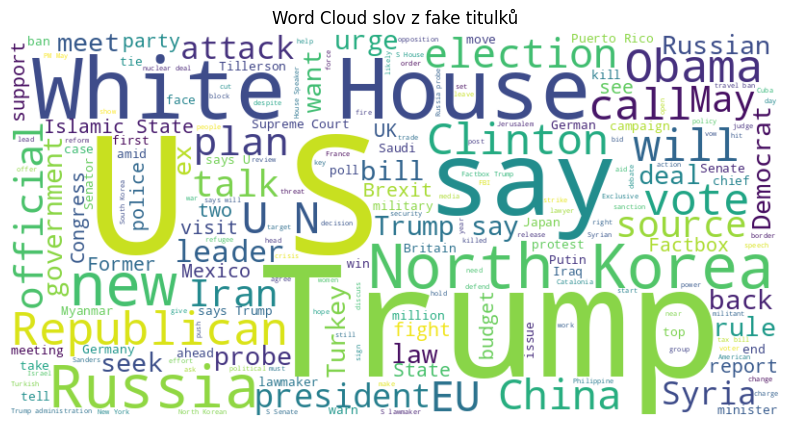

In [6]:
# Načtení původního datasetu
df = pd.read_csv("train (2).csv", sep=";")  # Uprav cestu k souboru podle potřeby

# Použití původních titulků místo predikovaných dat
df["Rekonstruovaný text"] = df["title"].astype(str)

# Zobrazení několika ukázkových fake textů (filtrujeme jen fake news)
df_fake = df[df["label"] == 1]  # Předpokládám, že 1 označuje fake news
print(df_fake[["Rekonstruovaný text", "label"]].head(20))

# Vytvoření Word Cloud pro fake titulky
fake_texts = " ".join(df_fake["Rekonstruovaný text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(fake_texts)

# Zobrazení Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud slov z fake titulků")
plt.show()

                                  Rekonstruovaný text  label
2    FAIL! The Trump Organization’s Credit Score W...      0
4   THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...      0
6   WATCH: John Oliver Presents GOP Debates As ‘Cl...      0
8    Trump HUMILIATES Republicans In Latest Hissy ...      0
9   MACY’S GETS THE BOOT FROM LOYAL CUSTOMERS AFTE...      0
12  ONE DEMOCRAT WHO REFUSES To Cast Electoral Vot...      0
13   WATCH: Senator Al Franken Just Ripped Ted Cru...      0
17  WOW! UNHINGED CLOWN DEMOCRAT Goes Nuts On Hous...      0
18   Heiress To Disney Empire Knows GOP Scammed Us...      0
19   Trump Staffers Admit Their Boss Has No Idea W...      0
23  WATCH: NANCY PELOSI COMES UNGLUED! Calls A Pie...      0
24   WATCH: Donald Trump Is OBSESSED With His Desi...      0
25  BIKERS FOR TRUMP Will Travel To Future Rallies...      0
26  “HILL”ARIOUS…MUST SEE! IOWA PARADE GOERS Treat...      0
27  [Video] BURGER KING MANAGER CURSES OUT AND THR...      0
28   ‘God Is Gay’: SNL D

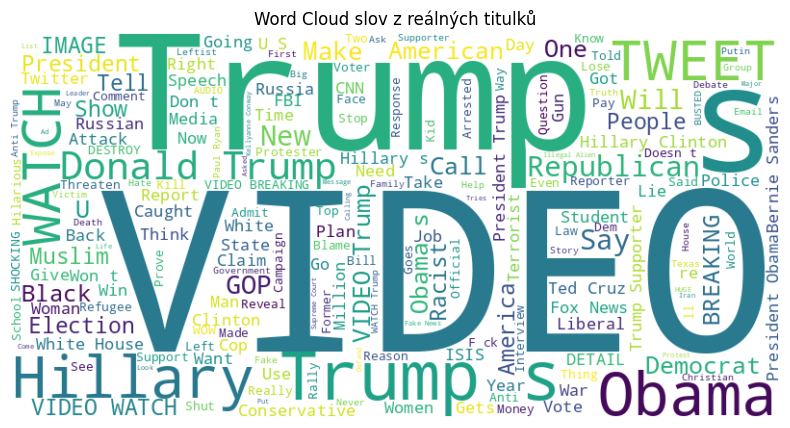

In [7]:
# Načtení původního datasetu
df = pd.read_csv("train (2).csv", sep=";")  # Uprav cestu k souboru podle potřeby

# Použití původních titulků místo predikovaných dat
df["Rekonstruovaný text"] = df["title"].astype(str)

# Filtrujeme jen reálné (pravdivé) titulky
df_real = df[df["label"] == 0]  # Předpokládám, že 0 označuje reálné zprávy
print(df_real[["Rekonstruovaný text", "label"]].head(20))

# Vytvoření Word Cloud pro reálné titulky
real_texts = " ".join(df_real["Rekonstruovaný text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(real_texts)

# Zobrazení Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud slov z reálných titulků")
plt.show()

Zde byl použit pouze klasifikační model:

In [ ]:
# data sets
test_df = pd.read_csv('test (1).csv', sep=';')
train_df = pd.read_csv('train (2).csv', sep=';')

# processing data
target_column = train_df.columns[-1]  #target column
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]

X_test = test_df.drop(columns=[target_column])
y_test = test_df[target_column]

# use same LabelEncoder for testing and training data
encoder = LabelEncoder()

# learning encoder on y_train
encoder.fit(y_train)

# transform both data sets
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)  # same encoder fo no errors

# transfer to  one-hot encoding
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

# processing text columns
text_columns = X_train.select_dtypes(include=['object']).columns
for col in text_columns:
    le = LabelEncoder()
    # Fit the LabelEncoder on the combined unique values from both train and test
    all_values = pd.concat([X_train[col], X_test[col]]).unique()
    le.fit(all_values)
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

# normalize numbers columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# neural network creation
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer"
    Dropout(0.3),  # Dropout to reduce overfitting
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.3),
    Dense(32, activation='relu'),  # Hidden layer
    Dense(y_train.shape[1], activation='softmax')  # Output layer (softmax for multiple classes)
])

# Model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# training model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# model evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  #converting probabilities to classes
y_test_classes = np.argmax(y_test, axis=1)

# displaying the classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

# displaying the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


762/762 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7189 - loss: 0.5589 - val_accuracy: 0.7551 - val_loss: 0.4868
Epoch 2/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7545 - loss: 0.5005 - val_accuracy: 0.7446 - val_loss: 0.4764
Epoch 3/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7602 - loss: 0.4846 - val_accuracy: 0.7722 - val_loss: 0.4653
Epoch 4/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7670 - loss: 0.4725 - val_accuracy: 0.7679 - val_loss: 0.4617
Epoch 5/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7688 - loss: 0.4618 - val_accuracy: 0.7741 - val_loss: 0.4391
Epoch 6/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7650 - loss: 0.4548 - val_accuracy: 0.7798 - val_loss: 0.4249
Epoch 7/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7703 - loss: 0.4407 - val_accuracy: 0.7883 - val_loss: 0.4054
Epoch 8/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7840 - loss: 0.4219 - val_accuracy: 0.8014 - val_

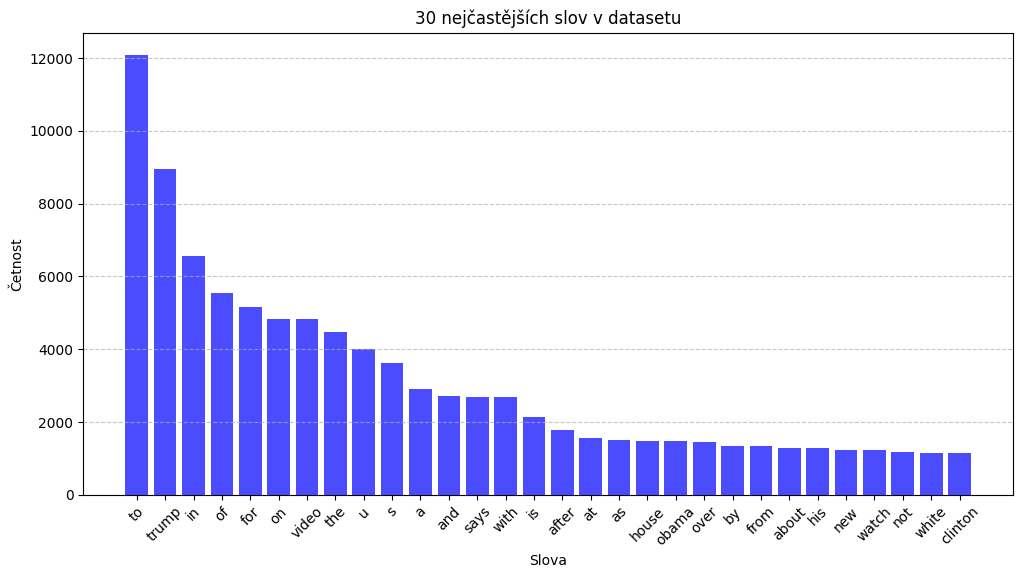

In [ ]:
#ssuming your data is in 'train (2).csv' and 'test (1).csv'
train_df = pd.read_csv('train (2).csv', sep=';')
test_df = pd.read_csv('test (1).csv', sep=';')
df_all = pd.concat([train_df, test_df]) # create df_all by concatenating train and test

#Ujistíme se, že 'title' neobsahuje NaN hodnoty
df_all['title'] = df_all['title'].astype(str).fillna("")

#Tokenizace všech textů v datasetu
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_all['title'])

#Počet slov v datasetu
word_counts = dict(tokenizer.word_counts)

#Seřazení slov podle četnosti (sestupně)
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

#Výběr 30 nejčastějších slov
top_words = sorted_word_counts[:30]
words, counts = zip(*top_words)  # Rozdělení na slova a jejich četnosti

#Graf distribuce četnosti slov
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='blue', alpha=0.7)
plt.xlabel("Slova")
plt.ylabel("Četnost")
plt.title("30 nejčastějších slov v datasetu")
plt.xticks(rotation=45)  # Otočení popisků osy X pro lepší čitelnost
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Zobrazení grafu
plt.show()

TF-IDF



In [ ]:
# Funkce pro načtení a spojení dat
def load_and_merge_data(train_path, test_path, submit_path):
    train_df = pd.read_csv(train_path, sep=';')
    test_df = pd.read_csv(test_path, sep=';')
    submit_df = pd.read_csv(submit_path, sep=';')
    test_df = pd.concat([test_df, submit_df], axis=0, ignore_index=True).drop(columns=["idS"], errors='ignore')
    df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    return df_all

# Funkce pro předzpracování dat pomocí TF-IDF a imputace
def preprocess_data(df):
    target_column = df.columns[-1]
    X = df.drop(columns=[target_column])
    Y = df[target_column]

    # Imputace chybějících numerických hodnot
    imputer = SimpleImputer(strategy='mean')
    X_num_imputed = pd.DataFrame(imputer.fit_transform(X.select_dtypes(include=np.number)), columns=X.select_dtypes(include=np.number).columns)

    # Transformace textových dat pomocí TF-IDF
    if 'title' in df.columns:
        tfidf_vectorizer = TfidfVectorizer(max_features=10000)
        X_title_tfidf = tfidf_vectorizer.fit_transform(df['title'].astype(str).str.lower().fillna("")).toarray()
    else:
        X_title_tfidf = np.zeros((X.shape[0], 10000))

    # Standardizace numerických dat
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num_imputed)

    # Sloučení numerických a textových dat
    X_final = np.hstack([X_num_scaled, X_title_tfidf])

    # Label encoding a one-hot encoding pro cílovou proměnnou
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_onehot = one_hot_encoder.fit_transform(Y_encoded.reshape(-1, 1))

    return X_final, Y_onehot

# Funkce pro vytvoření modelu
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Načtení a předzpracování dat
df_all = load_and_merge_data('train (2).csv', 'test (1).csv', 'evaluation.csv')
X, Y = preprocess_data(df_all)

# Rozdělení dat
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Vytvoření a trénování modelu
model = create_model(X_train.shape[1], y_train.shape[1])
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(X_train, y_train, epochs=40, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 47s 170ms/step - accuracy: 0.6965 - loss: 1.1894 - val_accuracy: 0.9245 - val_loss: 0.9221 - learning_rate: 3.0000e-04
Epoch 2/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 79s 160ms/step - accuracy: 0.9302 - loss: 0.6041 - val_accuracy: 0.9348 - val_loss: 0.6272 - learning_rate: 3.0000e-04
Epoch 3/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.9556 - loss: 0.5241 - val_accuracy: 0.9387 - val_loss: 0.5649 - learning_rate: 3.0000e-04
Epoch 4/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 83s 169ms/step - accuracy: 0.9706 - loss: 0.4640 - val_accuracy: 0.9373 - val_loss: 0.5635 - learning_rate: 3.0000e-04
Epoch 5/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 43s 169ms/step - accuracy: 0.9799 - loss: 0.4180 - val_accuracy: 0.9342 - val_loss: 0.5662 - learning_rate: 3.0000e-04
Epoch 6/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - accuracy: 0.9822 - loss: 0.3842 - val_accuracy: 0.9336 - val_loss: 0.5619 - learning_rate: 3.0000e-04
Epoch 7/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 41s 16

KeyboardInterrupt: 

**BERT**

Použití neuronové sítě s pomocí TensorFlow na klasifikační bázi - pokročilé zpracování textu

In [ ]:
# Funkce pro načtení a spojení dat
def load_and_merge_data(train_path, test_path, submit_path):
    train_df = pd.read_csv(train_path, sep=';')
    test_df = pd.read_csv(test_path, sep=';')
    submit_df = pd.read_csv(submit_path, sep=';')
    test_df = pd.concat([test_df, submit_df], axis=0, ignore_index=True).drop(columns=["idS"], errors='ignore')
    df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    return df_all

# Funkce pro předzpracování dat pomocí BERT a imputace
def preprocess_data(df):
    target_column = df.columns[-1]
    X = df.drop(columns=[target_column])
    Y = df[target_column]

    # Imputace chybějících numerických hodnot
    imputer = SimpleImputer(strategy='mean')
    X_num_imputed = pd.DataFrame(imputer.fit_transform(X.select_dtypes(include=np.number)), columns=X.select_dtypes(include=np.number).columns)

    # Použití BERT pro textové zpracování
    if 'title' in df.columns:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Používáme předtrénovaný BERT tokenizer
        model = BertModel.from_pretrained('bert-base-uncased')  # Používáme předtrénovaný BERT model

        # Ujistíme se, že 'title' obsahuje pouze textové hodnoty (řetězce)
        titles = df['title'].astype(str).fillna('')

        def get_bert_embeddings(texts):
            # Kontrola, že texts je seznam řetězců
            if isinstance(texts, str):
                texts = [texts]
            inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)  # Tensors pro BERT model
            with torch.no_grad():  # Deaktivujeme výpočet gradientů pro rychlejší inference
                outputs = model(**inputs)
            return outputs.last_hidden_state.mean(dim=1).numpy()  # Průměr posledních skrytých stavů jako embeddingy

        X_title_bert = get_bert_embeddings(titles.tolist())  # Vytváříme embeddingy pro texty
    else:
        X_title_bert = np.zeros((X.shape[0], 768))  # BERT embeddingy mají rozměr 768

    # Standardizace numerických dat
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num_imputed)

    # Sloučení numerických a textových dat
    X_final = np.hstack([X_num_scaled, X_title_bert])

    # Label encoding a one-hot encoding pro cílovou proměnnou
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_onehot = one_hot_encoder.fit_transform(Y_encoded.reshape(-1, 1))

    return X_final, Y_onehot

# Funkce pro vytvoření modelu
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Načtení a předzpracování dat
df_all = load_and_merge_data('train (2).csv', 'test (1).csv', 'evaluation.csv')
X, Y = preprocess_data(df_all)

# Rozdělení dat
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Vytvoření a trénování modelu
model = create_model(X_train.shape[1], y_train.shape[1])
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(X_train, y_train, epochs=40, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Neurální síť pro klasifikaci, která kombinuje numerické a textové vstupy.
Byl použit pouze sloupec "title".

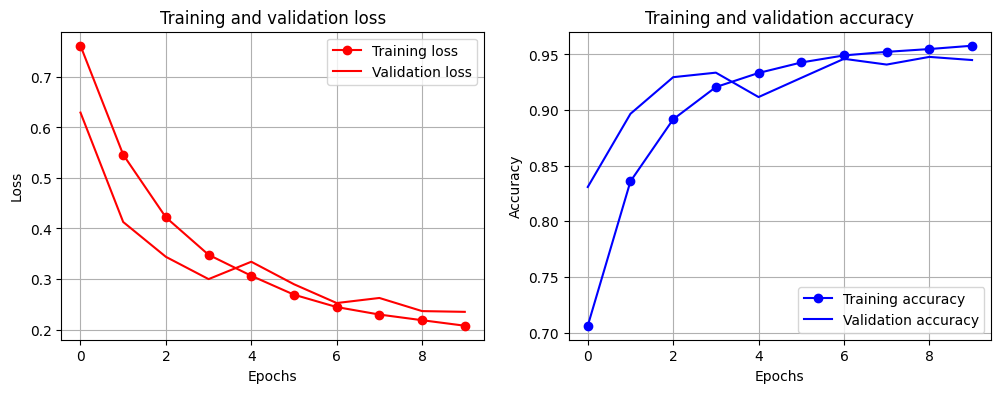

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3698
           1       0.95      0.96      0.95      4420

    accuracy                           0.95      8118
   macro avg       0.95      0.95      0.95      8118
weighted avg       0.95      0.95      0.95      8118


Confusion Matrix:


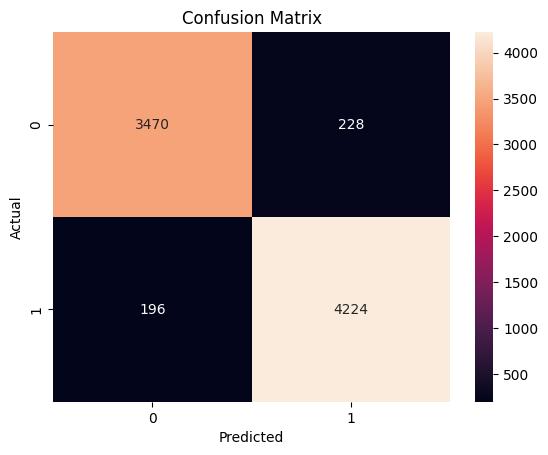

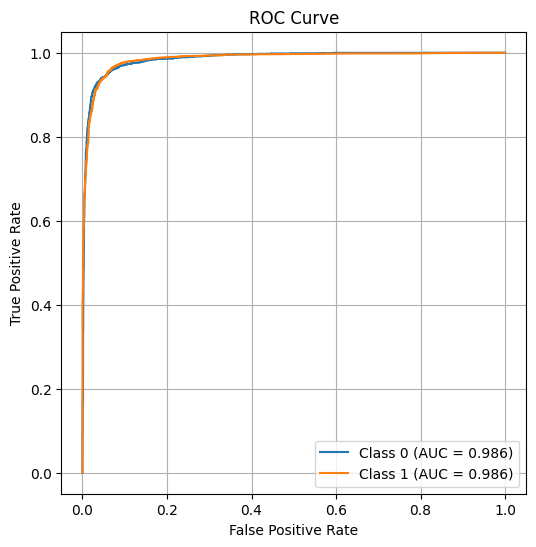

In [9]:
# Vizualizace průběhu trénování
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], "ro-", label="Training loss")
plt.plot(history.history["val_loss"], "r-", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], "bo-", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "b-", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.show()

# Predikce na testovacích datech
y_pred = model.predict([X_test_num, X_test_text])  # Predikce s oběma vstupy
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Klasifikační report a matice záměn
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC křivka a AUC skóre
plt.figure(figsize=(6, 6))
for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [8]:
# Načtení dat
def load_and_merge_data(train_path, test_path, submit_path):
    train_df = pd.read_csv(train_path, sep=';')
    test_df = pd.read_csv(test_path, sep=';')
    submit_df = pd.read_csv(submit_path, sep=';')
    test_df = pd.concat([test_df, submit_df], axis=0, ignore_index=True).drop(columns=["idS"], errors='ignore')
    df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    return df_all

# Funkce pro předzpracování dat
def preprocess_data(df, vocab_size=5000, max_length=100):
    target_column = df.columns[-1]
    X = df.drop(columns=[target_column])
    Y = df[target_column]

    # Imputace chybějících numerických hodnot
    imputer = SimpleImputer(strategy='mean')
    X_num_imputed = pd.DataFrame(imputer.fit_transform(X.select_dtypes(include=np.number)), columns=X.select_dtypes(include=np.number).columns)

    # Transformace textových dat pomocí embedding vrstvy
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")  # Použijeme max 5000 slov
    if 'title' in df.columns:
        titles = df['title'].astype(str).fillna("")
        tokenizer.fit_on_texts(titles)
        X_title_seq = tokenizer.texts_to_sequences(titles)  # Převedeme text na číselné indexy
        X_title_padded = pad_sequences(X_title_seq, maxlen=max_length, padding='post')  # Zkrátíme/rozšíříme délku na max_length
    else:
        X_title_padded = np.zeros((X.shape[0], max_length))  # Pokud title není, nastavíme nuly

    # Standardizace numerických dat
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num_imputed)


    # Label encoding a one-hot encoding pro cílovou proměnnou
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_onehot = one_hot_encoder.fit_transform(Y_encoded.reshape(-1, 1))

    return X_num_scaled, X_title_padded, Y_onehot, vocab_size, max_length # Return 5 items as line 43 expects

# Funkce pro vytvoření modelu
def create_model(input_shape, vocab_size, max_length, num_classes, embedding_dim=25): # Snížení embedding_dim
    input_num = Input(shape=(input_shape,))
    input_text = Input(shape=(max_length,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_text)
    flatten_layer = Flatten()(embedding_layer)
    merged = Concatenate()([input_num, flatten_layer])

    dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged) # Snížení neuronů a zvýšení L2
    dense = BatchNormalization()(dense) # Přidání BatchNormalization
    dense = Dropout(0.5)(dense) # Zvýšení Dropout rate

    dense = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense)
    dense = BatchNormalization()(dense) # Přidání BatchNormalization
    dense = Dropout(0.5)(dense) # Zvýšení Dropout rate

    dense = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense)
    dense = BatchNormalization()(dense) # Přidání BatchNormalization

    output = Dense(num_classes, activation='softmax')(dense)

    model = Model(inputs=[input_num, input_text], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy']) # Snížení learning rate

    return model

# Načtení a předzpracování dat
df_all = load_and_merge_data('train (2).csv', 'test (1).csv', 'evaluation.csv')
X_num, X_text, Y, vocab_size, max_length = preprocess_data(df_all)

X_train_num, X_test_num, X_train_text, X_test_text, y_train, y_test = train_test_split(X_num, X_text, Y, test_size=0.2, random_state=42)


# Vytvoření a trénování modelu
model = create_model(X_train_num.shape[1], vocab_size, max_length, y_train.shape[1])

model.summary()

early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, mode='max') # Úprava patience
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6, mode='max') # Úprava patience

history = model.fit([X_train_num, X_train_text], y_train,
                    epochs=10, batch_size=64, # Snížení epochs a batch_size
                    validation_data=([X_test_num, X_test_text], y_test),
                    callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 25)        │        125,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2500)           │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2501)           │              0 │ input_layer[0][0],     │
│                           │                        │                │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │        160,128 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64)             │            256 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32)             │            128 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │            528 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16)             │             64 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 2)              │             34 │ batch_normalization_2… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 288,218 (1.10 MB)

 Trainable params: 287,994 (1.10 MB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6413 - loss: 0.8586 - val_accuracy: 0.8309 - val_loss: 0.6294 - learning_rate: 1.0000e-04
Epoch 2/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8159 - loss: 0.5858 - val_accuracy: 0.8966 - val_loss: 0.4128 - learning_rate: 1.0000e-04
Epoch 3/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8816 - loss: 0.4430 - val_accuracy: 0.9295 - val_loss: 0.3439 - learning_rate: 1.0000e-04
Epoch 4/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9189 - loss: 0.3567 - val_accuracy: 0.9336 - val_loss: 0.2998 - learning_rate: 1.0000e-04
Epoch 5/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9317 - loss: 0.3168 - val_accuracy: 0.9117 - val_loss: 0.3342 - learning_rate: 1.0000e-04
Epoch 6/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9415 - loss: 0.2743 - val_accuracy: 0.9289 - val_loss: 0.2896 - learning_rate: 1.0000e-04
Epoch 7/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - 

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predikce na testovacích datech
y_pred_probs = model.predict(list(X_test_texts.values()))  # Pravděpodobnosti tříd
y_pred = y_pred_probs.argmax(axis=1)  # Převod na nejpravděpodobnější třídu
y_true = y_test.argmax(axis=1)  # Skutečné hodnoty

# Výpočet metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Výpis výsledků
print(f'🔹 Přesnost: {accuracy:.4f}')
print(f'🔹 Precision: {precision:.4f}')
print(f'🔹 Recall: {recall:.4f}')
print(f'🔹 F1-score: {f1:.4f}')


NameError: name 'model' is not defined

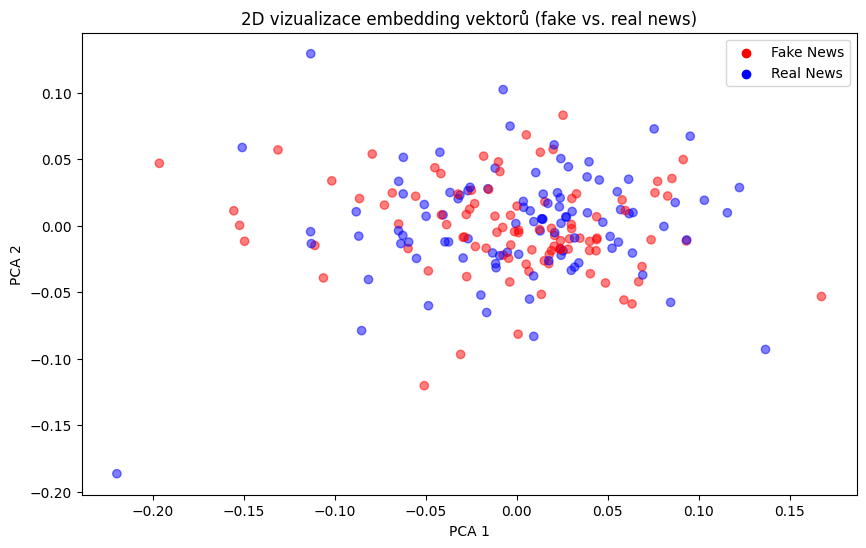

In [10]:
# Získání embedding váh
embedding_layer = model.get_layer("embedding")  # Název vrstvy může být jiný
weights = embedding_layer.get_weights()[0]

# Redukce dimenze na 2D
pca = PCA(n_components=2)
reduced_weights = pca.fit_transform(weights[:200])  # Omezíme na prvních 200 slov

# Získání labelů
labels = df_all['label'][:200]  # Předpokládáme, že prvních 200 labelů odpovídá prvním 200 slovům

# Přiřazení barev
colors = np.array(['red', 'blue'])  # Červená pro fake news, modrá pro real news
colored_labels = colors[labels]

# Vykreslení grafu s barevným kódováním
plt.figure(figsize=(10, 6))
plt.scatter(reduced_weights[:, 0], reduced_weights[:, 1], c=colored_labels, alpha=0.5)
plt.title("2D vizualizace embedding vektorů (fake vs. real news)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# Vytvoření legendy pomocí scatter plotů
legend_elements = [plt.scatter([], [], marker='o', color=colors[0], label='Fake News'),
                   plt.scatter([], [], marker='o', color=colors[1], label='Real News')]
plt.legend(handles=legend_elements)

plt.show()

Neurální síť pro klasifikaci, která kombinuje numerické a textové vstupy.
Byl použit slopec "title" i sloupec "news"

In [15]:
#Načtení dat
def load_and_merge_data(train_path, test_path, submit_path):
    train_df = pd.read_csv(train_path, sep=';')
    test_df = pd.read_csv(test_path, sep=';')
    submit_df = pd.read_csv(submit_path, sep=';')
    test_df = pd.concat([test_df, submit_df], axis=0, ignore_index=True).drop(columns=["idS"], errors='ignore')
    df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    return df_all

#Funkce pro předzpracování dat
def preprocess_data(df, vocab_size=10000, max_length=150):
    #Cílová proměnná
    Y = df['label']

    # Tokenizace textových sloupců
    tokenizers = {}
    X_text_padded = {}

    for col in ['title', 'text']:  #Zpracujeme oba textové sloupce
        tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
        texts = df[col].astype(str).fillna("")
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)
        X_text_padded[col] = pad_sequences(sequences, maxlen=max_length, padding='post')
        tokenizers[col] = tokenizer  #Uložíme tokenizer pro pozdější použití

    #Label encoding + OneHot encoding pro cílovou proměnnou
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_onehot = one_hot_encoder.fit_transform(Y_encoded.reshape(-1, 1))

    return X_text_padded, Y_onehot, vocab_size, max_length, tokenizers

#Funkce pro vytvoření modelu
def create_model(text_shapes, vocab_size, max_length, num_classes, embedding_dim=50):
    inputs = []
    processed_inputs = []

    #Embedding vrstvy pro textové vstupy
    for text_col, shape in text_shapes.items():
        input_text = Input(shape=(max_length,))
        embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(input_text)
        flatten_layer = Flatten()(embedding_layer)

        inputs.append(input_text)
        processed_inputs.append(flatten_layer)

    #Spojení všech vstupů
    merged = Concatenate()(processed_inputs)

    #Plně propojené vrstvy
    dense = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.4)(dense)

    dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.4)(dense)

    dense = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense)
    dense = BatchNormalization()(dense)

    output = Dense(num_classes, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Načtení a předzpracování dat
df_all = load_and_merge_data('train (2).csv', 'test (1).csv', 'evaluation.csv')
X_texts, Y, vocab_size, max_length, tokenizers = preprocess_data(df_all)  # Assign output to X_texts

# Rozdělení na trénovací a testovací sadu
df = df_all
X_train_texts = {col: X_texts[col][:int(0.8 * len(df))] for col in X_texts}
X_test_texts = {col: X_texts[col][int(0.8 * len(df)):] for col in X_texts}
y_train = Y[:int(0.8 * len(df))]
y_test = Y[int(0.8 * len(df)):]
#Vytvoření modelu
model = create_model(
    text_shapes={col: max_length for col in X_train_texts},
    vocab_size=vocab_size,
    max_length=max_length,
    num_classes=y_train.shape[1]
)

model.summary()

#Trénování modelu
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6, mode='max')

history = model.fit(
    list(X_train_texts.values()),
    y_train,
    epochs=8, batch_size=128,
    validation_data=(list(X_test_texts.values()), y_test),
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 150)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 150)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 150, 50)        │        500,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 150, 50)        │        500,000 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 7500)           │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 7500)           │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 15000)          │              0 │ flatten_3[0][0],       │
│ (Concatenate)             │                        │                │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │      1,920,128 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 128)            │            512 │ dense_8[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │          8,256 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 64)             │            256 │ dense_9[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │          2,080 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 32)             │            128 │ dense_10[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 2)              │             66 │ batch_normalization_8… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,931,426 (11.18 MB)

 Trainable params: 2,930,978 (11.18 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.6579 - loss: 1.0989 - val_accuracy: 0.6800 - val_loss: 0.9478 - learning_rate: 5.0000e-05
Epoch 2/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.8410 - loss: 0.7440 - val_accuracy: 0.9088 - val_loss: 0.6483 - learning_rate: 5.0000e-05
Epoch 3/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.9038 - loss: 0.6086 - val_accuracy: 0.9311 - val_loss: 0.5391 - learning_rate: 5.0000e-05
Epoch 4/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.9378 - loss: 0.5202 - val_accuracy: 0.9563 - val_loss: 0.4605 - learning_rate: 5.0000e-05
Epoch 5/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.9582 - loss: 0.4571 - val_accuracy: 0.9627 - val_loss: 0.4277 - learning_rate: 5.0000e-05
Epoch 6/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - accuracy: 0.9702 - loss: 0.4159 - val_accuracy: 0.9640 - val_loss: 0.4075 - learning_rate: 5.0000e-05
Epoch 7/8
254/254 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - ac

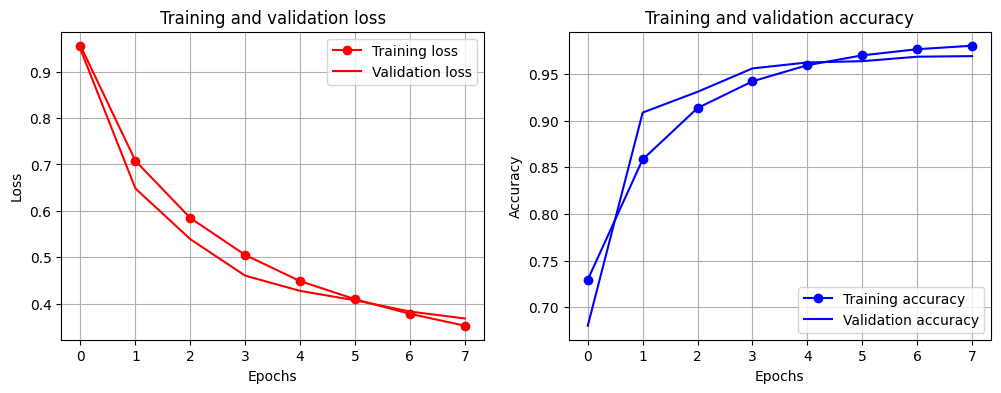

254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3804
           1       0.98      0.97      0.97      4314

    accuracy                           0.97      8118
   macro avg       0.97      0.97      0.97      8118
weighted avg       0.97      0.97      0.97      8118


Confusion Matrix:


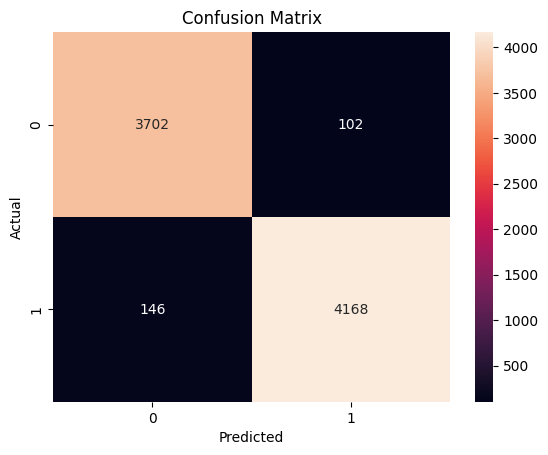

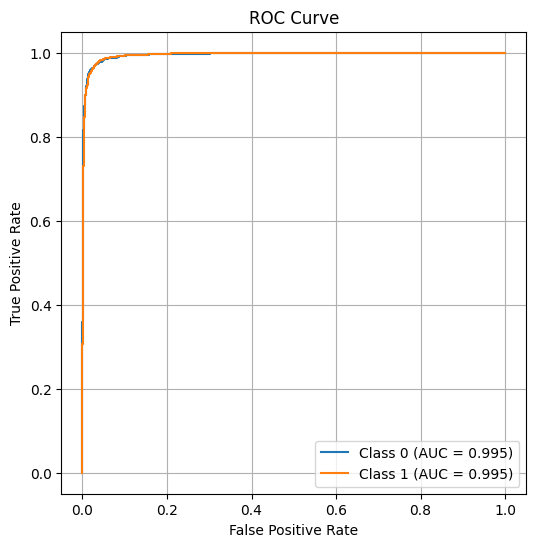

In [17]:
# Vizualizace průběhu trénování
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], "ro-", label="Training loss")
plt.plot(history.history["val_loss"], "r-", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], "bo-", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "b-", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.show()

# Predikce na testovacích datech
y_pred = model.predict(list(X_test_texts.values()))
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Klasifikační report a matice záměn
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_classes, y_pred_classes)

sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC křivka a AUC skóre
plt.figure(figsize=(6, 6))
for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predikce na testovacích datech
y_pred_probs = model.predict(list(X_test_texts.values()))  # Pravděpodobnosti tříd
y_pred = y_pred_probs.argmax(axis=1)  # Převod na nejpravděpodobnější třídu
y_true = y_test.argmax(axis=1)  # Skutečné hodnoty

# Výpočet metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Výpis výsledků
print(f'🔹 Přesnost: {accuracy:.4f}')
print(f'🔹 Precision: {precision:.4f}')
print(f'🔹 Recall: {recall:.4f}')
print(f'🔹 F1-score: {f1:.4f}')


254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
🔹 Přesnost: 0.9695
🔹 Precision: 0.9695
🔹 Recall: 0.9695
🔹 F1-score: 0.9695
